# Exercitiu #1
Folosind datasetul de la Auto MPG, trebuie sa implementam un model de clasificare care va trebui sa clasifice masinile in functie de eficienta consumului de combustibil.
<br><br>
Fiind o variabila de tip continuu, va trebui sa discretizam _MPG_ pe 3 intervale/clase posibile - low, medium & high efficiency. 
Vom urma urmatorii pasi:
1. Rescriem coloana _MPG_ incat sa contina un integer asociat cu clasa de eficienta
2. Preprocesam datele de intrare
3. Construim si antrenam modelul
4. Testam modelul si evaluam rezultatele

In [89]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
print("TensorFlow version installed: ", tf.__version__)

TensorFlow version installed:  2.12.0


In [90]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data' # url-ul din care vom prelua datasetul
columns = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin'] # atributele din dataset
classes = ['LOW', 'MED', 'HIGH'] # clasele de eficienta de consum al combustibilului

rawDataset = pd.read_csv(url, names=columns, na_values = '?', comment='\t', sep=' ', skipinitialspace=True) # citim datele
dataset = rawDataset.copy()
dataset = dataset.dropna()
dataset = dataset.drop(columns=['Origin']) # nu vom folosi regiunea de origine a masinii in predictia clasei de eficienta
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


In [91]:
lims = [0, 20, 30, float("inf")] # setam breakpoint-urile
labels = [0, 1, 2] # setam label-urile numerice pentru clasele de eficienta
dataset['Efficiency'] = pd.cut(dataset['MPG'], bins=lims, labels=labels, right=False) # construim o noua coloana pentru clasa de eficienta
dataset = dataset.drop(columns=['MPG']) # stergem coloana de MPG - nu o vom folosi

^ Am creat 4 breakpoint-uri pentru a clasifica masinile in functie de consumul de combustibil:
- [0, 20) - LOW efficiency | daca 0 <= MPG < 20 atunci consideram ca modelul masinii este ineficient
- [20, 30) - MED efficiency | daca 20 <= MPG < 30 atunci eficienta este medie
- [30, +$\infty$) - HIGH efficiency | daca MPG >= 30 atunci eficienra masinii este mare

<br><br>
Observatii:<br>
- float("inf") reprezinta +$\infty$
- numerele 0, 1, 2 vor fi asociate mai tarziu claselor LOW, MED, HIGH

In [92]:
dataset.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Efficiency
393,4,140.0,86.0,2790.0,15.6,82,1
394,4,97.0,52.0,2130.0,24.6,82,2
395,4,135.0,84.0,2295.0,11.6,82,2
396,4,120.0,79.0,2625.0,18.6,82,1
397,4,119.0,82.0,2720.0,19.4,82,2


In [93]:
toNormalize = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year'] # vector cu coloanele pe care le vom normaliza
for column in toNormalize:
    dataset[column] = pd.to_numeric(dataset[column])
    dataset[column] = (dataset[column] - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

^ normalizam valorile din coloanele folosite. De data asta, am facut normalizare manual, cu formula urmatoare:
$$
x_{i_{norm}} = \frac{x_i - min(D)}{max(D) - min(D)}, \quad i \in (0, n-1),\quad n = card(D)
$$
unde $D$ - o coloana din dataset (o multime finita de valori)<br><br>
Astfel mapam valorile tuturor atributelor pe intervalul (0, 1) - cea mai buna varianta cand lucram cu modele de ML.

In [94]:
dataset.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Efficiency
393,0.2,0.186047,0.217391,0.333711,0.452381,1.0,1
394,0.2,0.074935,0.032609,0.146583,0.988095,1.0,2
395,0.2,0.173127,0.206522,0.193365,0.214286,1.0,2
396,0.2,0.134367,0.179348,0.286929,0.630952,1.0,1
397,0.2,0.131783,0.195652,0.313864,0.678571,1.0,2


In [95]:
trainSet = dataset.sample(frac=0.8, random_state=0) # separam 80% pentru antrenare
testSet = dataset.drop(trainSet.index) # restul ramane pentru testare

In [96]:
trainFeatures = trainSet.copy()
testFeatures = testSet.copy()
trainLabels = trainFeatures.pop("Efficiency")
testLabels = testFeatures.pop("Efficiency")

^ este necesar sa separam atributele pe care le stim (**Features**) de atributul pe care vrem ca modelul sa invete sa il prezica (**Label** sau **Target**).<br><br>
Chiar si cand antrenam modelul, trebuie sa existe separarea asta: ii dam modelului datele, si apoi ii spunem carui fel de clasa apartin datele respective, ca apoi sa poata prezica clasa avand acces doar la date fara labels.

In [97]:
trainLabels = trainLabels.map({0: "LOW", 1: "MED", 2:"HIGH"})
trainLabels = pd.get_dummies(trainLabels).astype(np.float32).values
testLabels = testLabels.map({0: "LOW", 1: "MED", 2:"HIGH"})
testLabels = pd.get_dummies(testLabels).astype(np.float32).values


In [98]:
model = tf.keras.Sequential([
    #normalizer,                deoarece am facut normalizarea manual, nu mai avem nevoie de un strat de preprocesare
    tf.keras.layers.Flatten(input_shape=(6,)), # in schimb, trebuie sa definim un strat de input care va preia atributele cunoscute (care sunt 6 in total)
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax") # avem nevoie de 3 neuroni in stratul de output deoarece exista 3 clase posibile
])

In [99]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [100]:
%%time
history = model.fit(trainFeatures, trainLabels, epochs=100, validation_split=0.2, batch_size=8) 


Epoch 1/100
32/32 [==============================] - 1s 15ms/step - loss: 0.7322 - accuracy: 0.6175 - val_loss: 0.5212 - val_accuracy: 0.8254
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.5045 - accuracy: 0.7968 - val_loss: 0.4994 - val_accuracy: 0.8095
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.4433 - accuracy: 0.8167 - val_loss: 0.5244 - val_accuracy: 0.8254
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.4151 - accuracy: 0.8167 - val_loss: 0.4645 - val_accuracy: 0.8254
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.4148 - accuracy: 0.8446 - val_loss: 0.6487 - val_accuracy: 0.7778
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 0.4076 - accuracy: 0.8367 - val_loss: 0.4494 - val_accuracy: 0.8095
Epoch 7/100
32/32 [==============================] - 0s 11ms/step - loss: 0.4040 - accuracy: 0.8327 - val_loss: 0.4526 - val_accuracy: 0.8095
Epoch 8/

Text(0.5, 0, 'epoch')

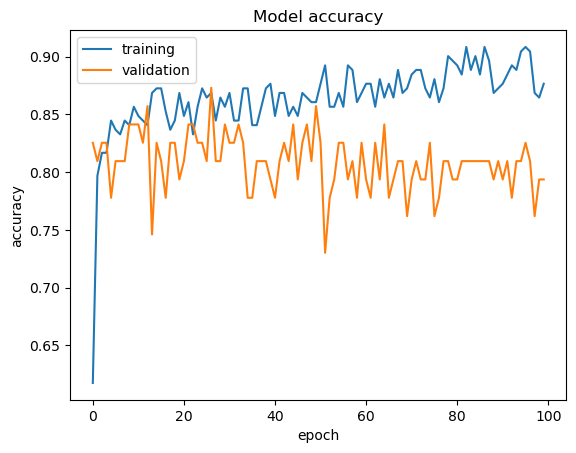

In [101]:
# Accuracy plot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.legend(["training", "validation"])
plt.xlabel("epoch")

In [102]:
loss, acc = model.evaluate(testFeatures, testLabels, verbose=2)
print("\n Accuracy: ", acc)

3/3 - 0s - loss: 0.4065 - accuracy: 0.8462 - 30ms/epoch - 10ms/step

 Accuracy:  0.8461538553237915


In [103]:
predictions = model.predict(testFeatures)

3/3 [==============================] - 0s 3ms/step


In [107]:
entry = 13 # orice numar intre 0 si 77, reprezinta indexul unui entry din datasetul de antrenare
print("Entry ", entry)
print("Probabilities: ", predictions[entry])
print(f"\nAnswer: {classes[np.argmax(predictions[entry])]} \t Actual: {classes[np.argmax(testLabels[entry])]}")
if np.argmax(predictions[entry]) == np.argmax(testLabels[entry]):
    print("\nPrediction CORRECT")
else:
    print("\nPrediction WRONG")

Entry  13
Probabilities:  [0.003 0.987 0.01 ]

Answer: MED 	 Actual: MED

Prediction CORRECT
